In [1]:
import simpy
import numpy as np
import random
from datetime import datetime, timedelta
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
virtual_queue = [
    {"flights": "BM2616", "time_slots": [4*3600], "capacity":[30]}, #Depature 05:45
    {"flights": "XC6333", "time_slots": [5.25*3600, 5.5*3600, 5.75*3600],"capacity":[20,20,5]}, #Depature 06:00
    {"flights": "OO2037", "time_slots": [5.5*3600, 5.75*3600, 6*3600], "capacity":[20,20,5]}, #Depature 06:15
    {"flights": "HP4524", "time_slots": [5.5*3600, 5.75*3600, 6*3600, 6.25*3600],"capacity":[10,20,5,10]}, #Depature 06:30
    {"flights": "DN7022", "time_slots": [6.5*3600, 6.25*3600, 6*3600],"capacity":[30,20,10]}, #Depature 06:45

    {"flights": "QX7315", "time_slots": [7*3600], "capacity":[20]}, #Depature 09:30
    {"flights": "SS2446", "time_slots": [9.25*3600, 9.5*3600], "capacity":[20, 20]}, #Depature 09:45
    {"flights": "ZI1701", "time_slots": [9.75*3600, 9.5*3600], "capacity":[20, 20]}, #Depature 10:00
    {"flights": "HC1255", "time_slots": [10*3600, 9.75*3600, 9.5*3600], "capacity":[20,20, 20]}, #Depature 10:15
    {"flights": "HF1818", "time_slots": [10.25*3600, 10*3600, ], "capacity":[20, 20]}, #Depature 10:30
    {"flights": "IG2596", "time_slots": [10.5*3600], "capacity":[40]} #Depature 10:45
]

In [3]:
def process_virtual_queue(passengers_data, virtual_queue):
    #Peak period 1: 04:15 - 05:15
    peak_periods1_start = 4.25*60*60
    peak_periods1_end = 5.25*60*60

    #Peak period 2: 07:30 - 09:00
    peak_periods2_start = 7.5*60*60
    peak_periods2_end = 9*60*60

    passengers_data["new_ArrivalTime"] = passengers_data["ArrivalTime"]
    passengers_data['Priority'] = 0
    
    # 遍历虚拟队列列表
    for flight_info in virtual_queue:
        flight_code = flight_info["flights"]
        time_slots = flight_info["time_slots"]
        capacities = flight_info["capacity"]

        # 获取符合条件的乘客
        eligible_passengers = passengers_data[((passengers_data['ArrivalTime'].between(peak_periods1_start, peak_periods1_end)) | 
                                           (passengers_data['ArrivalTime'].between(peak_periods2_start, peak_periods2_end))) & 
                                           (passengers_data['FlightNumber'] == flight_code)]

        # 随机选择乘客并分配到时间槽
        for i, passenger in eligible_passengers.iterrows():
            #如果所有时间槽都用完，可以在这里跳出循环
            if not time_slots:
                break

            time_slot = random.choice(time_slots)
            capacity = capacities[time_slots.index(time_slot)]

            # 检查时间槽容量是否用完
            if capacity == 0:
                continue

            # 生成随机到达时间，介于time_slot和time_slot + 15分钟之间
            random_arrival_time = random.uniform(time_slot, time_slot + 0.25 * 3600)

            # 进行相应的处理，例如更新到达时间、设置优先级等
            passengers_data.loc[i, 'new_ArrivalTime'] = random_arrival_time
            passengers_data.loc[i, 'Priority'] = 1  # 设置优先级

            # 减少相应时间槽的容量
            capacities[time_slots.index(time_slot)] -= 1

            # 如果时间槽容量用完，可以在这里移除该时间槽
            if capacities[time_slots.index(time_slot)] == 0:
                time_slots.remove(time_slot)
                
    passengers_data["new_ArrivalTime_formatted"] = passengers_data["new_ArrivalTime"].apply(lambda x: (datetime(1970, 1, 1) + timedelta(seconds=x)).strftime('%H:%M'))
    passengers_data["DepartureTime_formatted"] = passengers_data["DepartureTime"].apply(lambda x: (datetime(1970, 1, 1) + timedelta(seconds=x)).strftime('%H:%M'))

    return passengers_data

In [4]:
import simpy
import random
import pandas as pd

# 全局变量
waiting_time_list = []
virtual_waiting_time_list = []
normal_waiting_time_list = []
waiting_time_intervals = []
average_waiting_times = []
time_intervals_start = []
average_virtual_waiting_times = []
average_normal_waiting_times = []
virtual_queue_empty = True
time_interval = 15 * 60
MAX_WAIT_TIME = 10 * 60

def generate_processing_time():
    return random.expovariate(1 / 20.0)

def security_check(env, passenger_id, security_lanes, priority):
    global waiting_time_list, virtual_waiting_time_list, normal_waiting_time_list, waiting_time_intervals

    arrival_time = env.now

    if priority == 0:
        # 等待直到队列清空或达到最大等待时间
        start_wait_time = env.now
        while len(security_lanes[0].queue) > 0 and (env.now - start_wait_time) < MAX_WAIT_TIME:
            yield env.timeout(1)  # 短暂等待后再次检查队列

    shortest_lane = min(security_lanes, key=lambda x: len(x.queue))
    with shortest_lane.request() as request:
        yield request
        yield env.timeout(generate_processing_time())
        waiting_time = env.now - arrival_time
        waiting_time_list.append(waiting_time)
        if priority == 1:
            virtual_waiting_time_list.append(waiting_time)
        else:
            normal_waiting_time_list.append(waiting_time)
        waiting_time_intervals[-1].append(waiting_time)
        print(f"乘客{passenger_id}于{arrival_time}到达, 优先级: {priority}")
        print(f"乘客{passenger_id}于{env.now}完成安检（等待时间：{waiting_time}秒）")



def passenger_generator(env, security_lanes, passengers_data):
    for _, passenger in passengers_data.iterrows():
        passenger_id = passenger['Id']
        priority = passenger['Priority']
        arrival_time = passenger['new_ArrivalTime']
        yield env.timeout(max(0, arrival_time - env.now))  # 防止负延迟
        env.process(security_check(env, passenger_id, security_lanes, priority))

def adjust_security_lanes(env, security_lanes, security_data):
    for _, row in security_data.iterrows():
        time, lanes = row['Time'], row['Lanes']
        yield env.timeout(time - env.now)
        while len(security_lanes) < lanes:
            security_lanes.append(simpy.Resource(env, capacity=1))
        while len(security_lanes) > lanes:
            security_lanes.pop()

def calculate_average_waiting_time(env):
    global time_intervals_start, average_waiting_times
    global average_virtual_waiting_times, average_normal_waiting_times
    current_time = 0
    while True:
        yield env.timeout(time_interval)
        current_time += time_interval

        # 计算整体平均等待时间
        if waiting_time_intervals[-1]:
            avg_waiting_time = sum(waiting_time_intervals[-1]) / len(waiting_time_intervals[-1])
        else:
            avg_waiting_time = 0
        average_waiting_times.append(avg_waiting_time)

        # 计算虚拟队列的平均等待时间
        if virtual_waiting_time_list:
            avg_virtual_waiting_time = sum(virtual_waiting_time_list) / len(virtual_waiting_time_list)
        else:
            avg_virtual_waiting_time = 0
        average_virtual_waiting_times.append(avg_virtual_waiting_time)

        # 计算普通队列的平均等待时间
        if normal_waiting_time_list:
            avg_normal_waiting_time = sum(normal_waiting_time_list) / len(normal_waiting_time_list)
        else:
            avg_normal_waiting_time = 0
        average_normal_waiting_times.append(avg_normal_waiting_time)

        # 为下一个时间间隔准备
        time_intervals_start.append(current_time - time_interval)
        waiting_time_intervals.append([])
        virtual_waiting_time_list.clear()
        normal_waiting_time_list.clear()

def reset_globals():
    global waiting_time_list, virtual_waiting_time_list, normal_waiting_time_list
    global waiting_time_intervals, average_waiting_times, time_intervals_start
    global average_virtual_waiting_times, average_normal_waiting_times, virtual_queue_empty
    
    waiting_time_list = []
    virtual_waiting_time_list = []
    normal_waiting_time_list = []
    waiting_time_intervals = [[]]
    average_waiting_times = []
    average_virtual_waiting_times = []
    average_normal_waiting_times = []
    time_intervals_start = []
    virtual_queue_empty = True

def run_simulation(sim_time, passengers_data, security_data):
    reset_globals()

    env = simpy.Environment()
    initial_lanes = security_data['Lanes'].iloc[0]
    security_lanes = [simpy.Resource(env, capacity=1) for _ in range(initial_lanes)]
    
    waiting_time_intervals.append([])

    env.process(passenger_generator(env, security_lanes, passengers_data))
    env.process(adjust_security_lanes(env, security_lanes, security_data))
    env.process(calculate_average_waiting_time(env))

    env.run(until=sim_time)
    df_avg_waiting_times = pd.DataFrame({
        'Average Waiting Time': average_waiting_times,
        'Average Virtual Queue Waiting Time': average_virtual_waiting_times,
        'Average Normal Queue Waiting Time': average_normal_waiting_times
    }, index=time_intervals_start)
    return df_avg_waiting_times

def multiple_run_simulation(runs, sim_time, passengers_data, security_data):
    total_avg_waiting_times = None
    for i in range(runs):
        print(f"正在运行模拟 {i+1}/{runs}")
        average_waiting_time_df = run_simulation(sim_time, passengers_data, security_data)
        if total_avg_waiting_times is None:
            total_avg_waiting_times = average_waiting_time_df
        else:
            total_avg_waiting_times = total_avg_waiting_times.add(average_waiting_time_df, fill_value=0)

    overall_average = total_avg_waiting_times / runs
    return overall_average

In [5]:
# 数据导入
passengers_data = pd.read_csv('passengers_0.csv')
security_data = pd.read_csv('security.csv')
flights_data = pd.read_csv('flights.csv')
passengers_data = pd.merge(passengers_data, flights_data, left_on='FlightNumber', right_on='FlightNumber', how='left')
passengers_data = process_virtual_queue(passengers_data, virtual_queue).sort_values(by='new_ArrivalTime')


In [6]:
passengers_data

,Id,ArrivalTime,FlightNumber,DepartureTime,Passengers,new_ArrivalTime,Priority,new_ArrivalTime_formatted,DepartureTime_formatted
208,7W4SUIW8P60C9EZHVKY7,8233.117982,XC6333,21600,130,8233.117982,0,02:17,06:00
139,TGR0H5TWSF84MFMQUX8C,8276.390512,XC6333,21600,130,8276.390512,0,02:17,06:00
593,9U7304Z48YAGBHLRQ2C1,8868.483377,DN7022,24300,193,8868.483377,0,02:27,06:45
22,KMIZ1FTYWSB0LAQWT1YX,8892.912112,BM2616,20700,80,8892.912112,0,02:28,05:45
67,EH1RELRCS1FWEAKAN0XN,9024.329169,BM2616,20700,80,9024.329169,0,02:30,05:45
...,...,...,...,...,...,...,...,...,...
1517,TXQCW8FRFDY5B5Q94OF8,30468.411293,IG2596,38700,153,38691.885856,1,10:44,10:45
1464,Q4I3WXRO23PCUJWX8IAM,32311.650226,IG2596,38700,153,38693.529966,1,10:44,10:45
1487,C6DTEQGJOQAACSBW4TPW,30173.934118,IG2596,38700,153,38694.610116,1,10:44,10:45
1484,X4ICO0UXB9V564PCOER4,29406.183168,IG2596,38700,153,38697.339595,1,10:44,10:45


In [7]:
# 运行多次模拟
simulation_result_df = multiple_run_simulation(5, 40000, passengers_data, security_data)
print(simulation_result_df)

正在运行模拟 1/5
乘客7W4SUIW8P60C9EZHVKY7于8233.11798182214到达, 优先级: 0
乘客7W4SUIW8P60C9EZHVKY7于8255.924741333887完成安检（等待时间：22.80675951174635秒）
乘客TGR0H5TWSF84MFMQUX8C于8276.390512008185到达, 优先级: 0
乘客TGR0H5TWSF84MFMQUX8C于8276.765842002036完成安检（等待时间：0.3753299938507553秒）
乘客9U7304Z48YAGBHLRQ2C1于8868.483377069739到达, 优先级: 0
乘客9U7304Z48YAGBHLRQ2C1于8871.7212994442完成安检（等待时间：3.23792237446105秒）
乘客KMIZ1FTYWSB0LAQWT1YX于8892.912111878226到达, 优先级: 0
乘客KMIZ1FTYWSB0LAQWT1YX于8900.148213208084完成安检（等待时间：7.2361013298577745秒）
乘客EH1RELRCS1FWEAKAN0XN于9024.329169188到达, 优先级: 0
乘客EH1RELRCS1FWEAKAN0XN于9044.572459225541完成安检（等待时间：20.243290037540646秒）
乘客NV7KUEARJML65WN17FCG于9106.285121659166到达, 优先级: 0
乘客NV7KUEARJML65WN17FCG于9111.752141567938完成安检（等待时间：5.467019908772272秒）
乘客5PPT0WWE5IP8IFFGFLJH于10188.54801089032到达, 优先级: 0
乘客5PPT0WWE5IP8IFFGFLJH于10197.389829478088完成安检（等待时间：8.841818587769012秒）
乘客ZJ61OIMBSX93FYQ8URVD于10345.716468004674到达, 优先级: 0
乘客ZJ61OIMBSX93FYQ8URVD于10394.621005204383完成安检（等待时间：48.90453719970901秒）
乘客EFVX4UN9YTAC9KH8O36P

In [8]:
non_zero_values = simulation_result_df[simulation_result_df['Average Waiting Time'] != 0]
non_zero_count = non_zero_values['Average Waiting Time'].count()
simulation_result_df['Average Waiting Time'].sum()/non_zero_count

197.4197101545973

In [9]:
simulation_result_df["Time in hour"] = simulation_result_df.index/3600
simulation_result_df

,Average Waiting Time,Average Virtual Queue Waiting Time,Average Normal Queue Waiting Time,Time in hour
0,0.000000,0.000000,0.000000,0.00
900,0.000000,0.000000,0.000000,0.25
1800,0.000000,0.000000,0.000000,0.50
2700,0.000000,0.000000,0.000000,0.75
3600,0.000000,0.000000,0.000000,1.00
4500,0.000000,0.000000,0.000000,1.25
5400,0.000000,0.000000,0.000000,1.50
6300,0.000000,0.000000,0.000000,1.75
7200,0.000000,0.000000,0.000000,2.00
8100,17.965896,0.000000,17.965896,2.25


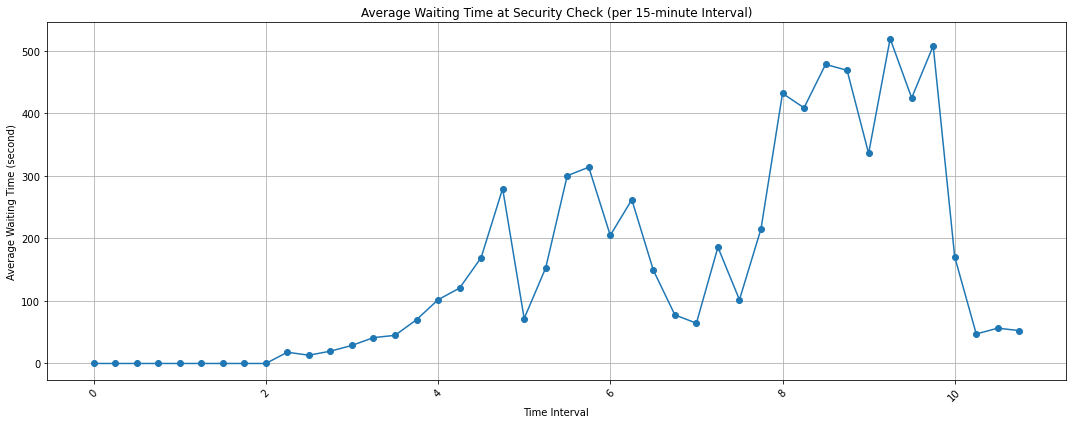

In [10]:
import matplotlib.pyplot as plt
# Plotting
plt.figure(figsize=(15, 6))
plt.plot(simulation_result_df['Time in hour'], simulation_result_df['Average Waiting Time'], marker='o')
plt.title('Average Waiting Time at Security Check (per 15-minute Interval)')
plt.xlabel('Time Interval')
plt.ylabel('Average Waiting Time (second)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

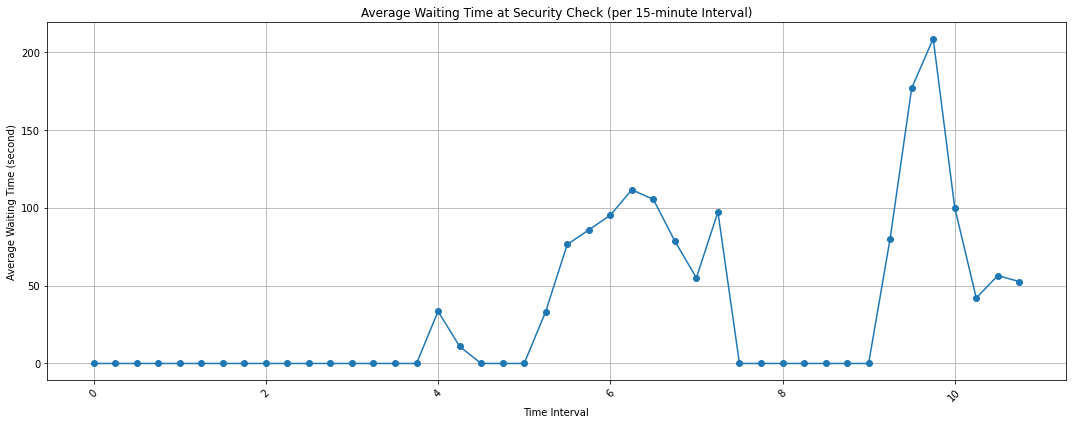

In [11]:
plt.figure(figsize=(15, 6))
plt.plot(simulation_result_df['Time in hour'], simulation_result_df['Average Virtual Queue Waiting Time'], marker='o')
plt.title('Average Waiting Time at Security Check (per 15-minute Interval)')
plt.xlabel('Time Interval')
plt.ylabel('Average Waiting Time (second)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

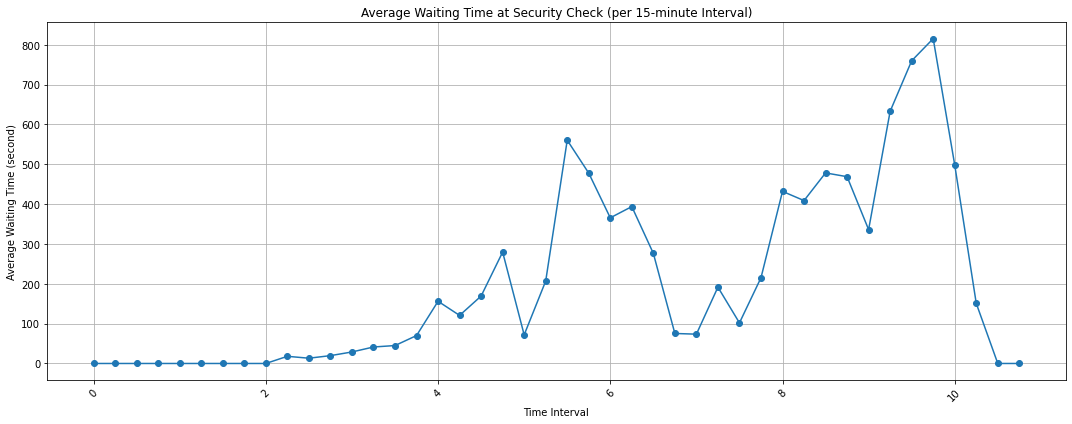

In [12]:
plt.figure(figsize=(15, 6))
plt.plot(simulation_result_df['Time in hour'], simulation_result_df['Average Normal Queue Waiting Time'], marker='o')
plt.title('Average Waiting Time at Security Check (per 15-minute Interval)')
plt.xlabel('Time Interval')
plt.ylabel('Average Waiting Time (second)')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()